<a href="https://colab.research.google.com/github/Hassan7838/text-based-emotion-recognition/blob/main/text-based-emotion-recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Text-Based Emotion Recognition Using NLP and Deep Learning

# Essential Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# PyTorch and Hugging Face Transformers
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [ ]:
# Upload Dataset
from google.colab import files
uploaded = files.upload()

Saving Emotions.csv to Emotions (1).csv


In [ ]:
# Load and Explore Dataset
df = pd.read_csv('Emotions.csv', sep=";", header=None, names=["text", "emotion"])
print("Dataset Shape:", df.shape)
print("\nOriginal Label Distribution:\n", df['emotion'].value_counts(), sep="")
print(df.head(10))
# data is already cleaned so there is no need of cleaning it

Dataset Shape: (2000, 2)

Original Label Distribution:
emotion
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64
                                                text  emotion
0  im feeling rather rotten so im not very ambiti...  sadness
1          im updating my blog because i feel shitty  sadness
2  i never make her separate from me because i do...  sadness
3  i left with my bouquet of red and yellow tulip...      joy
4    i was feeling a little vain when i did this one  sadness
5  i cant walk into a shop anywhere where i do no...     fear
6   i felt anger when at the end of a telephone call    anger
7  i explain why i clung to a relationship with a...      joy
8  i like to have the same breathless feeling as ...      joy
9  i jest i feel grumpy tired and pre menstrual w...    anger


In [ ]:
# Encode Labels
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['emotion'])
num_classes = len(label_encoder.classes_)
print(f"\nEncoded Classes: {list(zip(label_encoder.classes_, range(num_classes)))}")


Encoded Classes: [('anger', 0), ('fear', 1), ('joy', 2), ('love', 3), ('sadness', 4), ('surprise', 5)]


In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['encoded_label'],
    test_size=0.3, random_state=42, stratify=df['encoded_label'])

In [ ]:
# --- DistilBERT Model Setup ---
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# Tokenize the datasets
def tokenize_data(texts, labels, max_length=128):
    encodings = tokenizer(
        list(texts),
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt"
    )
    return {
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'labels': torch.tensor(labels.values if hasattr(labels, 'values') else labels)
    }

train_encodings = tokenize_data(X_train, y_train)
test_encodings = tokenize_data(X_test, y_test)

In [ ]:
# Create PyTorch datasets
test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    test_encodings['labels'])
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    train_encodings['labels'])

In [ ]:
# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Load pre-trained DistilBERT
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_classes,
    id2label={i: label for i, label in enumerate(label_encoder.classes_)},
    label2id={label: i for i, label in enumerate(label_encoder.classes_)}
).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Using device: cpu


In [ ]:
# Training setup
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Training loop with progress tracking
print("\n--- Training DistilBERT ---")
model.train()
for epoch in range(3):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch_idx, (input_ids, attention_mask, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Calculate accuracy
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if batch_idx % 10 == 0:
            accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
            print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}, Acc: {accuracy:.3f}')

    avg_loss = total_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions
    print(f'Epoch {epoch+1} completed. Avg Loss: {avg_loss:.4f}, Acc: {epoch_accuracy:.3f}')


--- Training DistilBERT ---
Epoch 1, Batch 0, Loss: 1.7966, Acc: 0.125
Epoch 1, Batch 10, Loss: 1.6535, Acc: 0.284
Epoch 1, Batch 20, Loss: 1.6485, Acc: 0.321
Epoch 1, Batch 30, Loss: 1.4768, Acc: 0.323
Epoch 1, Batch 40, Loss: 1.6052, Acc: 0.341
Epoch 1, Batch 50, Loss: 1.5238, Acc: 0.350
Epoch 1, Batch 60, Loss: 1.3729, Acc: 0.368
Epoch 1, Batch 70, Loss: 1.3365, Acc: 0.386
Epoch 1, Batch 80, Loss: 1.5053, Acc: 0.401
Epoch 1 completed. Avg Loss: 1.5236, Acc: 0.415
Epoch 2, Batch 0, Loss: 1.3377, Acc: 0.562
Epoch 2, Batch 10, Loss: 0.8489, Acc: 0.608
Epoch 2, Batch 20, Loss: 1.2445, Acc: 0.598
Epoch 2, Batch 30, Loss: 0.8974, Acc: 0.625
Epoch 2, Batch 40, Loss: 0.6304, Acc: 0.651
Epoch 2, Batch 50, Loss: 1.0132, Acc: 0.653
Epoch 2, Batch 60, Loss: 1.0526, Acc: 0.654
Epoch 2, Batch 70, Loss: 1.1269, Acc: 0.667
Epoch 2, Batch 80, Loss: 0.9603, Acc: 0.679
Epoch 2 completed. Avg Loss: 0.9508, Acc: 0.689
Epoch 3, Batch 0, Loss: 0.7075, Acc: 0.875
Epoch 3, Batch 10, Loss: 0.6540, Acc: 0.81

In [ ]:
# --- Evaluation ---
print("\n--- Evaluating on Test Set ---")
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.numpy())

print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=label_encoder.classes_))


--- Evaluating on Test Set ---
Classification Report:
              precision    recall  f1-score   support

       anger       0.87      0.73      0.79        82
        fear       0.67      0.88      0.76        67
         joy       0.92      0.94      0.93       209
        love       0.72      0.65      0.68        48
     sadness       0.88      0.93      0.90       174
    surprise       1.00      0.05      0.10        20

    accuracy                           0.85       600
   macro avg       0.84      0.70      0.69       600
weighted avg       0.86      0.85      0.84       600



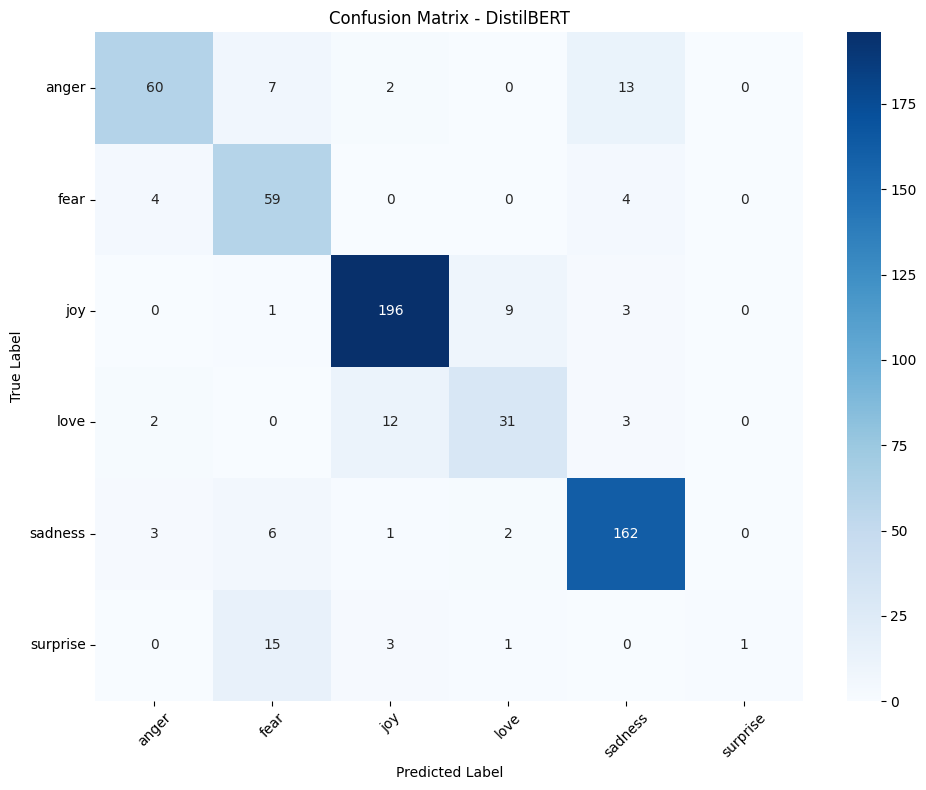

In [ ]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - DistilBERT')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# --- Prediction Function ---
def predict_emotion(text):
    """
    Predict emotion from raw text using the fine-tuned DistilBERT model.
    Returns the predicted emotion and a confidence score.
    """
    model.eval()

    # tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)

    # Move to device and get prediction
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        probabilities = torch.softmax(outputs.logits, dim=-1)
        confidence, predicted_class_id = torch.max(probabilities, dim=-1)

    confidence = confidence.item()
    predicted_class_id = predicted_class_id.item()
    predicted_emotion = label_encoder.inverse_transform([predicted_class_id])[0]

    # Adaptive confidence threshold
    if confidence < 0.3:
        # Get top-2 predictions for mixed emotions
        top_probs, top_indices = torch.topk(probabilities[0], 2)
        top_emotions = label_encoder.inverse_transform(top_indices.cpu().numpy())
        predicted_emotion = f"Unclear/Mixed ({top_emotions[0]}: {top_probs[0].item():.2f}, {top_emotions[1]}: {top_probs[1].item():.2f})"

    return predicted_emotion, confidence

In [ ]:
# --- CLI Interface ---
print("\n" + "="*50)
print("Text Emotion Recognition CLI (DistilBERT)")
print("Type 'quit' to exit the program.")
print("="*50)

print("\n---Welcome---")
while True:
    user_input = input("\nPlease enter a sentence to analyze its emotion: ").strip()

    if user_input.lower() == 'quit':
        print("Goodbye!")
        break
    if not user_input:
        continue

    emotion, confidence = predict_emotion(user_input)
    print(f"\nPredicted Emotion: {emotion}")
    print(f"Confidence: {confidence:.4f}")


Text Emotion Recognition CLI (DistilBERT)
Type 'quit' to exit the program.

---Welcome---

Please enter a sentence to analyze its emotion: i am so happy today

Predicted Emotion: joy
Confidence: 0.9339

Please enter a sentence to analyze its emotion: I am sad because i failed in exam

Predicted Emotion: sadness
Confidence: 0.8708

Please enter a sentence to analyze its emotion: I love this food very much

Predicted Emotion: love
Confidence: 0.4773

Please enter a sentence to analyze its emotion: Hurrah! we won the match

Predicted Emotion: joy
Confidence: 0.7887

Please enter a sentence to analyze its emotion: i surprise to see you here

Predicted Emotion: joy
Confidence: 0.7358

Please enter a sentence to analyze its emotion: I scared from darkness

Predicted Emotion: fear
Confidence: 0.8266

Please enter a sentence to analyze its emotion: quit
Goodbye!
